In [118]:
import matplotlib as mpl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models

from keras import utils

# Tira os warning do TF
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

# Constantes

In [377]:
ULTIMOS_DIGITOS_MATRICULA = [0, 7] # 7 cavalo e 0 Avião
QTD_EPOCAS = 20
N_CLASSES = 10

NUM_BATCH_SIZE = 128
NUM_EPOCHS = 10

# Obtendo Dados

In [278]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
#(a, aa), (b, bb) = datasets.mnist.load_data()

# Exemplo das imagens

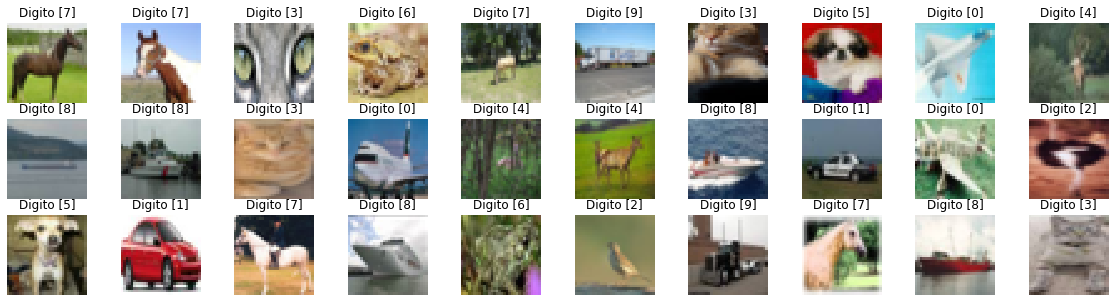

In [280]:
n_rows = 3
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i], cmap="gray")
        axes[i][j].set_title("Digito {}".format(y_train[img_i]))
        axes[i][j].axis("off")
plt.show()

# Obtendo o formato da imagem e a quantidade de imagens

In [281]:
img_shape = x_train.shape[1:]

#Converte o vetor obtido no dataset para ONE-HOT ENCODING
y_train = utils.to_categorical(y_train, N_CLASSES)
y_test = utils.to_categorical(y_test, N_CLASSES)

# Normalização dos dados

In [282]:
x_train = x_train/255
x_test = x_test/255

# Separando dados em parte A e B

In [364]:
#Verifica se a imagem(vector) é da classe contida no número de matrícula
def verify_class(vector):
    for i in ULTIMOS_DIGITOS_MATRICULA:
        if (vector[i] == 1.0):
            return 1
    return 0

#Obtêm os indices das imagens que são da classe [0 ou 7], que são os últimos digitos da matricula.
index_train_digit = list(filter(lambda x: verify_class(y_train[x]) == 1, range(y_train.shape[0])))
index_test_digit = list(filter(lambda x: verify_class(y_test[x]) == 1, range(y_test.shape[0])))
#index_test_digit = list(filter(lambda x: y_test[x] in (ULTIMOS_DIGITOS_MATRICULA), range(len(y_test))))

#Cria a parte B dos dados
b_x_train = x_train[index_train_digit]
b_y_train = y_train[index_train_digit]
b_x_test = x_test[index_test_digit]
b_y_test = y_test[index_test_digit]

#Cria os dados da parte A, removendo os indices presentes em B
a_x_train = np.delete(x_train, index_train_digit, 0)
a_y_train = np.delete(y_train, index_train_digit, 0)
a_x_test = np.delete(x_test, index_test_digit, 0)
a_y_test = np.delete(y_test, index_test_digit, 0)

# Definindo CNN

O modelo CNN tem basicamente 2 camadas de convolução seguidas de 1 pooling. Essa repetição ocorre 2 vezes até chegar nas duas camadas densa.

In [381]:
def load_cnn_model():
    model_input = layers.Input(shape=img_shape, name="Input")

    # 2 camadas de convolucao e 1 de pooling que
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1")(model_input)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool1")(x)

    # 2 camadas de convolucao e 1 de pooling que
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3")(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool2")(x)

    # Camada que "achata" para depois usar em camadas fully connected
    x = layers.Flatten(name="Flatten")(x)

    # Camada fully connected (aqui chamada de Dense)
    x = layers.Dense(256, activation="relu", name="Dense1")(x)

    # Dropout com a probabilide de remover cada neuronio
    x = layers.Dropout(0.5, name="Dropout")(x)

    # Ultima camada com ativacao softmax, que tem como saida 
    # uma probabilidade para cada classe
    model_output = layers.Dense(N_CLASSES, activation='softmax', name="OutpuLayer")(x)

    model = models.Model(model_input, model_output)
    model.summary()
    
    return model

In [382]:
def execute_model(model, x_train, y_train, x_test, y_test):
    
    # O Adam algoritmo é uma otimização do tradicional Stochastic Gradient Descent. Geralmente alcanca um bom resultado mais rapidamente.
    optimizer = optimizers.Adam(lr=0.01)

    # Compila o modelo, escolhendo a funcao de perda e a metrica principal
    model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Treinando a rede
    result = model.fit(x_train, y_train, batch_size=NUM_BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))
    return result

# Treinando a parte (A) dos dados

In [383]:
cnn_model = load_cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

**Treinando a Primeira parte dos dados**

In [ ]:
def plot_confusion_matrix(model, x_train, y_train):
    # Predições
    y_proba = model.predict(x_train)
    y_pred = np.argmax(y_proba, axis=1)

    # Labels (desfaz o one-hot encode)
    y_true = np.argmax(y_train, axis=1)

    cm = metrics.confusion_matrix(y_true, y_pred)
    classes = list(range(1, 11))
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=classes, yticklabels=classes,
    title="Matriz de Confusão",
    ylabel="Real",
    xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    plt.show()